In [33]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flask import Flask, jsonify

from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurements', 'stations']


In [6]:
# Assign the stations class to a variable called `Station`
Station = Base.classes.stations
print(list(Station.__table__.columns))

# Assign the measurements class to a variable called `Measurement`
Measurement = Base.classes.measurements
print(list(Measurement.__table__.columns))

[Column('id', INTEGER(), table=<stations>, primary_key=True, nullable=False), Column('station', VARCHAR(length=255), table=<stations>), Column('name', VARCHAR(length=255), table=<stations>), Column('latitude', FLOAT(), table=<stations>), Column('longitude', FLOAT(), table=<stations>), Column('elevation', FLOAT(), table=<stations>)]
[Column('id', INTEGER(), table=<measurements>, primary_key=True, nullable=False), Column('station', VARCHAR(length=255), table=<measurements>), Column('date', DATETIME(), table=<measurements>), Column('prcp', FLOAT(), table=<measurements>), Column('tobs', FLOAT(), table=<measurements>)]


In [7]:
# Create a session
session = Session(engine)

In [8]:
# Precipitation Analysis

# Query date and prcp from measurements for dats greater than 1/1/2017
prcp_data_df = pd.read_sql("SELECT date, prcp FROM measurements WHERE date > '2017-01-01'", engine, index_col='date')

# reformat date to %Y-%m-%d format
prcp_data_df.index = pd.to_datetime(prcp_data_df.index, format="%Y-%m-%d")

print(f'there are {len(prcp_data_df)} rows of data')
prcp_data_df.head()

there are 1267 rows of data


,prcp
date,
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0


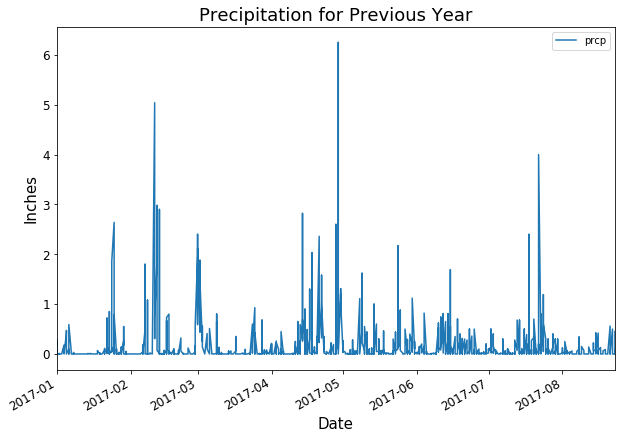

In [9]:
# plot dataframe
prcp_data_df.plot(figsize=(10, 7))

# change fontsize of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add title and axis labels
plt.title('Precipitation for Previous Year', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Inches', fontsize=15)

plt.show()

In [10]:
# print summary stats
prcp_data_df.describe()

,prcp
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


In [11]:
# Station Analysis
# Design a query to calculate the total number of stations.
total_stations = (session
                  .query(func.count(Station.name))
                  .scalar())

print(f'There are {total_stations} stations')

There are 9 stations


In [12]:
# Design a query to find the most active stations.
most_active_stations = (session
                        .query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .limit(3)
                        .all())

print('The 3 stations with the most activity are:\n')

highest_measurement_count = 0
most_active_station = None

for station in most_active_stations:
    
    print(f'Station Name: {station[0]}\nMeasurements: {station[1]}\n')
    
    if station[1] > highest_measurement_count:
        
        most_active_station = station[0]
        
        highest_measurement_count = station[1]
            
print(f'The most active station is {most_active_station}')                

The 3 stations with the most activity are:

Station Name: USC00519281
Measurements: 2772

Station Name: USC00513117
Measurements: 2696

Station Name: USC00519397
Measurements: 2685

The most active station is USC00519281


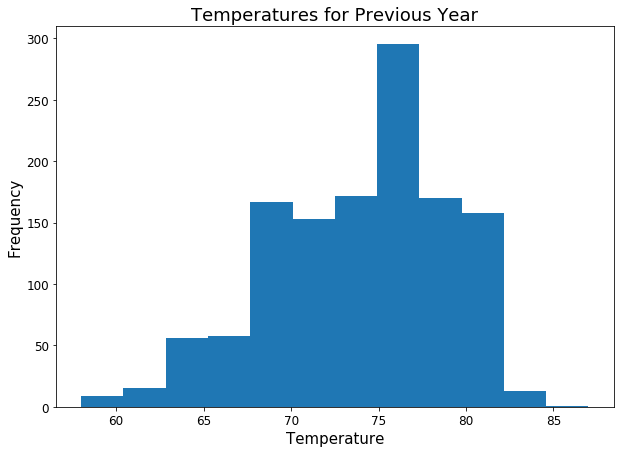

In [13]:
# retrieve the last 12 months of temperature observation data (tobs)
tobs = (session
        .query(Measurement.tobs)
        .filter(Measurement.date > '2017-01-01'))

# create numpy array to hold tobs values
tob_values = []

for tob in tobs:
    
    tob_values.append(tob[0])

tob_values_array = np.array(tob_values)

plt.figure(figsize=(10, 7))
plt.hist(tob_values_array, bins=12)

# change fontsize of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add title and axis labels
plt.title('Temperatures for Previous Year', fontsize=18)
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.show()

In [40]:
# Temperature Analysis
# function to calculate the minimum, average, and maximum temperatures for specified date range
def calc_temps(start_date, end_date):
    
    converted_start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    converted_end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    
    converted_start_date = converted_start_date - relativedelta(years=1)
    converted_end_date = converted_end_date - relativedelta(years=1)     
    
    print(f'these are the temp stats for {start_date} to {end_date} last year:')
    
    # query for min temp
    temp_min = (session
                .query(func.min(Measurement.tobs))
                .filter(Measurement.date >= converted_start_date)
                .filter(Measurement.date <= converted_end_date)
                .scalar())
    
    print(f'Min: {temp_min}')
    
    # query for max temp
    temp_max = (session
                .query(func.max(Measurement.tobs))
                .filter(Measurement.date >= converted_start_date)
                .filter(Measurement.date <= converted_end_date)
                .scalar())  
    
    print(f'Max: {temp_max}')    
    
    # query for average temp
    temp_avg = (session
                .query(func.avg(Measurement.tobs))
                .filter(Measurement.date >= converted_start_date)
                .filter(Measurement.date <= converted_end_date)
                .scalar())

    print(f'Avg: {temp_avg}')
    
    # return dictionary of temp stats
    return {'min': temp_min, 'max': temp_max, 'avg': temp_avg}

In [41]:
# define trip start and trip end date
trip_start = '2018-06-02'
trip_end = '2018-06-18'

# pull stats for trips dates in the previous year
trip_stats = calc_temps(trip_start, trip_end)

these are the temp stats for 2018-06-02 to 2018-06-18 last year:
Min: 72.0
Max: 83.0
Avg: 77.27173913043478


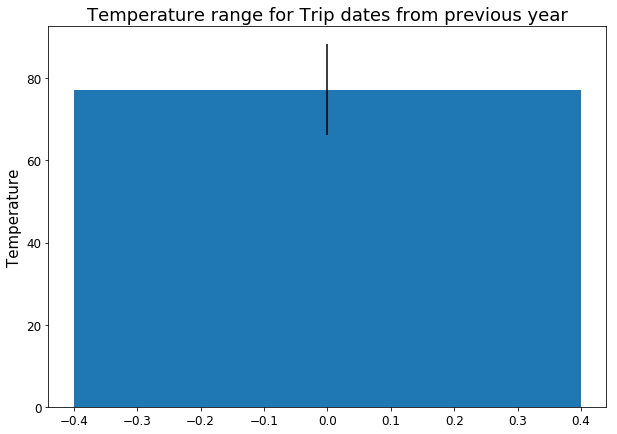

In [42]:
# plot previous year stats on bar plot
plt.figure(figsize=(10, 7))
plt.bar(0, trip_stats['avg'], yerr=(trip_stats['max']-trip_stats['min']))

# change fontsize of x and y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add title and axis labels
plt.title('Temperature range for Trip dates from previous year', fontsize=18)
plt.ylabel('Temperature', fontsize=15)

plt.show()